In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd

In [40]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [44]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [47]:
# Explore what the data looks like (Measurement table)
engine.execute('select * from Measurement ORDER BY date desc limit 10 ').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

In [48]:
# Inspect column names (Measurement table)
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [49]:
# Explore what the data looks like (Station table)
engine.execute('select * from Station limit 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [50]:
# Inspect column names (Measurement table)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


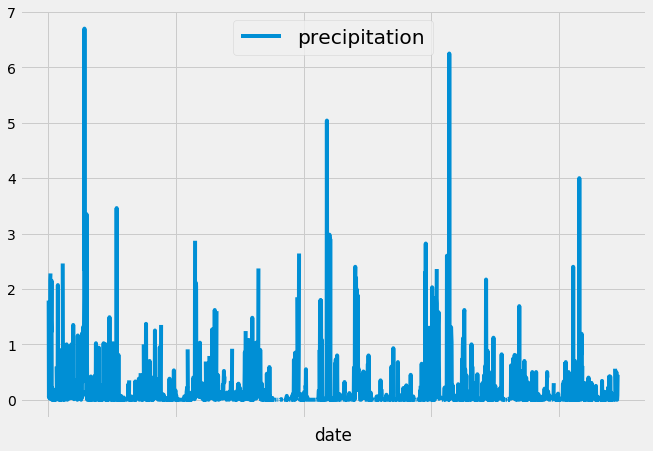

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = engine.execute('select date from Measurement ORDER BY date desc limit 1').fetchall()[0][0]
# Subtract 12 months/1 year from date for timeframe requested
entered_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
entered_date = entered_date.date()
twelve_months_ago = entered_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       Measurement.prcp]
last_12_prcp = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= twelve_months_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_12_prcp, columns=['date', 'prcp'])
prcp_df = prcp_df.set_index(['date'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date', ascending=True)

# Fill NA values with 0
#prcp_df = prcp_df.fillna(0)

# Use Pandas Plotting with Matplotlib to plot the data
style.use('fivethirtyeight')
prcp_plot = prcp_df.plot(use_index=True, y='prcp', figsize=(10,7))
plt.legend(["precipitation"], loc="best", fontsize = 'x-large')

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [53]:
# Design a query to show how many stations are available in this dataset?
num_stations = engine.execute('SELECT COUNT(DISTINCT name) FROM Station').fetchall()[0][0]
print("There are " + str(num_stations) + " stations available in this dataset.")

There are 9 stations available in this dataset.


In [54]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("""SELECT station,
                  COUNT(Measurement.id)
                  FROM Measurement
                  GROUP BY station
                  ORDER BY 2 desc
                  """).fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute("""SELECT MIN(tobs),
                         MAX(tobs),
                         AVG(tobs)
                  FROM Measurement
                  WHERE station = 'USC00519281'
                  """).fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [56]:
engine.execute("""SELECT station,
                         COUNT(tobs)
                  FROM Measurement
                  WHERE tobs is not null
                  GROUP BY 1
                  ORDER BY 2 desc
                  """).fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Text(0.5, 1.0, '')

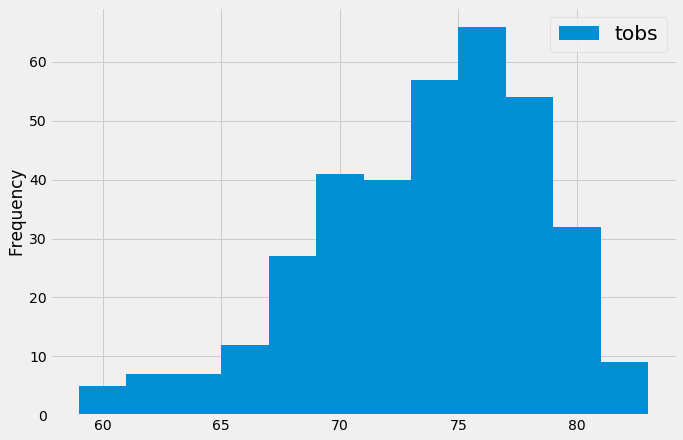

In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database
max_date = engine.execute("select date from Measurement WHERE station = 'USC00519281' ORDER BY date desc limit 1").fetchall()[0][0]
# Subtract 12 months/1 year from date for timeframe requested
entered_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
entered_date = entered_date.date()
twelve_months_ago = entered_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.tobs, Measurement.date]
last_12_temp = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= twelve_months_ago).\
    filter(Measurement.station == 'USC00519281').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(last_12_temp, columns=['tobs','date'])


# Use Pandas Plotting with Matplotlib to plot the data
style.use('fivethirtyeight')
temp_hist = temp_df.hist(bins=12, figsize=(10,7))
plt.legend(["tobs"], loc="best", fontsize = 'x-large')
plt.ylabel("Frequency")
plt.title(label="")

In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-04-07', '2017-04-14'))

[(67.0, 74.58, 82.0)]


In [59]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-04-07'
end_date = '2017-04-14'

start_prev_year = (dt.datetime.strptime(start_date, '%Y-%m-%d').date() - dt.timedelta(days=365)).strftime('%Y-%m-%d')
end_prev_year = (dt.datetime.strptime(end_date, '%Y-%m-%d').date() - dt.timedelta(days=365)).strftime('%Y-%m-%d')

prev_temps = calc_temps(start_prev_year, end_prev_year)
print(prev_temps)

[(65.0, 73.44, 78.0)]


([], <a list of 0 Text xticklabel objects>)

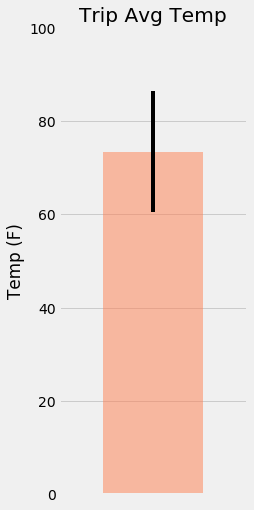

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tavg = prev_temps[0][1]
tmin = prev_temps[0][0]
tmax = prev_temps[0][2]

y_error = tmax - tmin

style.use('fivethirtyeight')
plt.figure(figsize=(3,8))
plt.title("Trip Avg Temp")
plt.bar(tavg,tavg, color='coral', alpha=.5, yerr=y_error)
plt.ylim(0, 100)
plt.xlim(tavg - .75,tavg + .75)
plt.ylabel("Temp (F)")
plt.xticks([])

In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

date_filter = "m.date >= '" + start_prev_year + "' AND m.date <= '" + end_prev_year + "'"

prcp_query = engine.execute("""SELECT   s.station,
                                   s.name,
                                   s.latitude,
                                   s.longitude,
                                   s.elevation,
                                   SUM(m.prcp)
                           FROM    Station s
                           JOIN    Measurement m ON m.station = s.station
                           WHERE   """ + date_filter + " GROUP BY s.station ORDER BY SUM(m.prcp) desc"
                        ).fetchall()

prcp_query

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.2800000000000002),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.3199999999999994),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.03),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.35),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [62]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [63]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
month_days = []

# Set the start and end date of the trip
date1 = start_prev_year
date2 = end_prev_year

# Use the start and end date to create a range of dates
date_list = pd.date_range(start=date1, end=date2, freq="D")

# Stip off the year and save a list of %m-%d strings
for x in date_list:
    date_parts = dt.datetime.strptime((str(x).split(' ', 1)[0]), "%Y-%m-%d")
    month_days.append(str(date_parts.month).zfill(2)  + '-' + str(date_parts.day).zfill(2))

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in month_days:
    normals.append(daily_normals(date)[0])
    
normals

[(63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0)]

In [64]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norms = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
norms['date'] = date_list
norms = norms.set_index('date')
norms

,tmin,tavg,tmax
date,,,
2016-04-07,63.0,71.105263,78.0
2016-04-08,66.0,72.105263,77.0
2016-04-09,62.0,71.614035,78.0
2016-04-10,64.0,71.403509,79.0
2016-04-11,65.0,72.491803,82.0
2016-04-12,65.0,72.224138,80.0
2016-04-13,64.0,71.525424,79.0
2016-04-14,65.0,72.750000,81.0


Text(0, 0.5, 'Temp (F)')

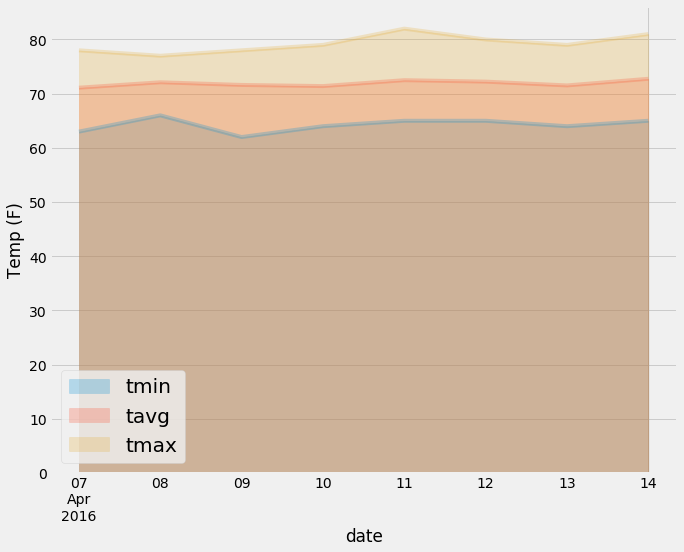

In [65]:
# Plot the daily normals as an area plot with `stacked=False`
style.use('fivethirtyeight')
norms.plot.area(stacked = False, alpha = .25, figsize=(10,8))
plt.legend(loc="best", fontsize = 'x-large')
plt.ylabel("Temp (F)")